In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import string
# from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from zipfile import ZipFile

In [ ]:
n = len(os.listdir("/content/drive/MyDrive/captcha"))
n

10000

In [ ]:
characters = string.ascii_lowercase + "0123456789"
nchar = len(characters)
Image_Size = (50,200,1)
print(nchar)

36


In [ ]:
try:
    img = cv2.imread("/content/drive/My Drive/captcha/22224x_9074.jpg", cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Failed to load the image.")
    else:
        print("Image shape:", img.shape)
except Exception as e:
    print("An error occurred:", str(e))


Image shape: (50, 200)


In [ ]:
def preprocess():
    X = []
    y = []

    for i, image in enumerate(os.listdir("/content/drive/My Drive/captcha")):
        img = cv2.imread(os.path.join("/content/drive/My Drive/captcha", image), cv2.IMREAD_GRAYSCALE)
        labels = image.split('_')[0]

        if len(labels) < 7 and img is not None:
            img = img / 255
            img = np.reshape(img, (50, 200, 1))

            target = np.zeros((6, nchar))

            for j, k in enumerate(labels):
                index = characters.find(k)
                target[j, index] = 1

            X.append(img)
            y.append(target)

    return np.array(X), np.array(y)



In [ ]:
dataset = []
for i, image in enumerate(os.listdir("/content/drive/My Drive/captcha")):

    labels = image.split('_')[0]
    dataset.append((str(image), labels))

dataset = pd.DataFrame(dataset, columns=["image", "labels"], index=None)

dataset = dataset.sample(frac=1.).reset_index(drop=True)


print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Total number of samples in the dataset:  10000


,image,labels
0,8gxxe8_3659.jpg,8gxxe8
1,p58ame_697.jpg,p58ame
2,nxd585_6249.jpg,nxd585
3,8d72yx_6561.jpg,8d72yx
4,62g74g_1941.jpg,62g74g


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
def createmodel():
    img = layers.Input(shape=Image_Size)
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn3 = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn3)


    flat = layers.Flatten()(mp3)

    output = []
    for _ in range(6):
        dense1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dense1)
        result = layers.Dense(nchar, activation='softmax')(drop)

        output.append(result)

    model = models.Model(img, output)
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = createmodel();
model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 200, 16)          160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 25, 100, 16)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 25, 100, 32)          4640      ['max_pooling2d[0][0]']   

In [ ]:
X, y = preprocess()

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets separately for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, [y_train[:, i] for i in range(6)], epochs=12, batch_size=32, validation_split=0.1)

Epoch 1/12
225/225 [==============================] - 4s 18ms/step - loss: 3.3333 - dense_1_loss: 0.5638 - dense_3_loss: 0.6038 - dense_5_loss: 0.6802 - dense_7_loss: 0.5146 - dense_9_loss: 0.3728 - dense_11_loss: 0.5981 - dense_1_accuracy: 0.7980 - dense_3_accuracy: 0.7744 - dense_5_accuracy: 0.7470 - dense_7_accuracy: 0.8076 - dense_9_accuracy: 0.8558 - dense_11_accuracy: 0.7730 - val_loss: 0.7926 - val_dense_1_loss: 0.1069 - val_dense_3_loss: 0.1853 - val_dense_5_loss: 0.2072 - val_dense_7_loss: 0.1511 - val_dense_9_loss: 0.0781 - val_dense_11_loss: 0.0640 - val_dense_1_accuracy: 0.9787 - val_dense_3_accuracy: 0.9475 - val_dense_5_accuracy: 0.9600 - val_dense_7_accuracy: 0.9650 - val_dense_9_accuracy: 0.9737 - val_dense_11_accuracy: 0.9825
Epoch 2/12
225/225 [==============================] - 3s 13ms/step - loss: 2.8559 - dense_1_loss: 0.5155 - dense_3_loss: 0.5303 - dense_5_loss: 0.5561 - dense_7_loss: 0.4284 - dense_9_loss: 0.3348 - dense_11_loss: 0.4908 - dense_1_accuracy: 0.8128

In [ ]:
def decode_predictions(predictions):
    decoded_predictions = []
    for i in range(len(predictions[0])):
        captcha = ""
        for j in range(6):
            character_probabilities = predictions[j][i]
            character_index = np.argmax(character_probabilities)
            character = characters[character_index]
            captcha += character
        decoded_predictions.append(captcha)
    return decoded_predictions
# Make predictions on the test set
predictions = model.predict(X_test)

# Decode predictions and ground truth labels
decoded_predictions = decode_predictions(predictions)
decoded_labels = ["".join([characters[np.argmax(y_test[i][j])] for j in range(6)]) for i in range(len(y_test))]

# Calculate overall accuracy
correct = 0
total = len(decoded_labels)

for i in range(total):
    if decoded_predictions[i] == decoded_labels[i]:
        correct += 1

overall_accuracy = (correct / total)*100
print("Overall Accuracy:", overall_accuracy)



63/63 [==============================] - 0s 3ms/step
Overall Accuracy: 91.25


In [ ]:
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    if img is not None:
        img = img / 255.0
        res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
        result = np.reshape(res, (6, 36))
        k_ind = []
        for i in result:
            k_ind.append(np.argmax(i))

        capt = ''
        for k in k_ind:
            capt += characters[k]
        return capt
    else:
        print("Image not detected")
        return None


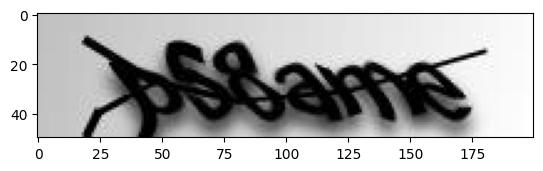

In [ ]:
img=cv2.imread('/content/drive/My Drive/captcha/p58ame_697.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
predicted_captcha = predict('/content/drive/My Drive/captcha/p58ame_697.jpg')
if predicted_captcha is not None:
    print("Predicted Captcha =", predicted_captcha)
else:
    print("Image not detected, prediction failed.")


1/1 [==============================] - 0s 40ms/step
Predicted Captcha = p58ame
